In [1]:
import sys
src_dir = '/Users/palmerio/Science_projects/GRB_population_model/grbpop/'
sys.path.insert(0, src_dir)
from GRB_population import GRBPopulation, create_GRB_population_from
import physics as ph
import numpy as np
import io_grb_pop as io
import miscellaneous as msc
from cosmology import init_cosmology, Lum_dist
from ECLAIRs import init_ECLAIRs
import plotting_functions as pf
import functional_forms as ff
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import logging
import f90_functions as f90f
from pathlib import Path
import stats as st
import cosmology as cs
import constants as cst

import scipy.integrate as integrate


log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG,
                    format='%(asctime)s.%(msecs)03d [%(levelname)s] %(message)s',
                    datefmt='%H:%M:%S')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
plt.style.use('presentation')

In [2]:
paths_to_dir, paths_to_files = io.generate_paths()

13:17:48.800 [DEBUG] Root directory is /Users/palmerio/Science_projects/GRB_population_model
13:17:48.802 [DEBUG] Directory paths :
    'root'    : /Users/palmerio/Science_projects/GRB_population_model
    'obs'     : /Users/palmerio/Science_projects/GRB_population_model/observational_constraints
    'init'    : /Users/palmerio/Science_projects/GRB_population_model/init
    'output'  : /Users/palmerio/Science_projects/GRB_population_model/model_outputs
    'data'    : /Users/palmerio/Science_projects/GRB_population_model/data
    'cosmo'   : /Users/palmerio/Science_projects/GRB_population_model/data/cosmology
    'ECLAIRs' : /Users/palmerio/Science_projects/GRB_population_model/data/ECLAIRs
13:17:48.802 [DEBUG] File paths :
    'config'          : /Users/palmerio/Science_projects/GRB_population_model/init/config.yml
    'param'           : /Users/palmerio/Science_projects/GRB_population_model/init/parameters.yml
    'instrum'         : /Users/palmerio/Science_projects/GRB_population_mo

In [80]:
config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
config['Nb_GRBs'] = '1e5'
config['samples'] = ['Stern', 'ECLAIRs', 'ECLAIRsS']
config['constraints'] = ['Stern', 'EpGBM', 'eBAT6']
config['output_dir'] = 'debugger'
paths_to_dir['output']=Path('/Users/palmerio/Science_projects/GRB_population_model/model_outputs/debugger/')

14:33:50.020 [DEBUG] Input configuration:
Nb_GRBs: 1e5
constraints:
- Stern
- EpGBM
- eBAT6
output_dir: debugger
samples:
- Stern
- EpGBM
- eBAT6
- Swift
- ECLAIRs
- SHOALS
- GBM_sample
- BATSE_5B_sample

14:33:50.023 [DEBUG] Input parameters:
Cvar_distribution:
    correl_slope: -0.413
    mu: 0.04
    sigma: 0.22
luminosity_function:
    k_evol: 1.0
    logLbreak: 52.56
    logLmax: 53.0
    logLmin: 49.6989700043
    model: ES
    slope: 1.41
peak_energy_distribution:
    Ep0: 690
    L0: 1.6e52
    alpha_amati: 0.3
    model: LN
    sigmaEp: 0.45
redshift_distribution:
    a: 0.94
    b: -0.52
    model: BExp
    zm: 2.18
    zmax: 20
spectral_shape:
    alpha: 0.6
    beta: 2.5
    model: GBM
    shape: Band
t90obs_distribution:
    mu: 1.45
    sigma: 0.47



In [126]:
cosmo = init_cosmology(paths_to_dir['cosmo'])
ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                            Emin=instruments['ECLAIRs']['Emin'],
                            Emax=120.,#instruments['ECLAIRs']['Emax'],
                            n_sigma=5.)
samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']

incl_samples, incl_instruments, incl_constraints = io.create_config(config=config,
                                                       samples=samples,
                                                       instruments=instruments,
                                                       obs_constraints=obs_constraints)

14:51:48.405 [DEBUG] Read cosmology from directory /Users/palmerio/Science_projects/GRB_population_model/data/cosmology: [0.3, 0.7, 0.7]
14:51:48.406 [DEBUG] ==============================================
14:51:48.406 [DEBUG] ===           ECLAIRs instrument           ===
14:51:48.407 [DEBUG] ==============================================
14:51:48.408 [DEBUG] ECLAIRs energy channel: 4.0 to 120.0 keV
14:51:48.409 [DEBUG] ECLAIRs detection level: 5.0 sigmas
14:51:48.437 [DEBUG] Effective area: from 1.013650e+02 cm2 at 4.00 keV
14:51:48.437 [DEBUG] Effective area: to   1.811580e+02 cm2 at 250.00 keV
14:51:48.438 [DEBUG] Background: from 2.819620e+02 cts/s/keV at 4.00 keV
14:51:48.439 [DEBUG] Background: to   8.730200e-02 cts/s/keV at 250.00 keV
14:51:48.439 [DEBUG] ECLAIRs background: 3.075475e+03 cts/s from 4.00 keV to 120.00 keV
14:51:48.441 [DEBUG] ==============================================
14:51:48.443 [INFO] Including samples: ['Stern', 'ECLAIRs', 'ECLAIRsS', 'EpGBM', 'eBAT6']
14

In [14]:
Nb_GRBs_list = [1e4, 5e4, 1e5, 5e5, 1e6]
chi2 = np.zeros((len(Nb_GRBs_list),4))
lnL = np.zeros((len(Nb_GRBs_list),4))
for i, Nb_GRBs in enumerate(Nb_GRBs_list):
    gp = create_GRB_population_from(Nb_GRBs=Nb_GRBs,
                                    cosmo=cosmo,
                                    params=params,
                                    incl_samples=incl_samples,
                                    incl_instruments=incl_instruments,
                                    incl_constraints=incl_constraints,
                                    output_dir=paths_to_dir['output'])
    chi2[i][0] = gp.likelihood_params['chi2_tot']
    chi2[i][1] = gp.likelihood_params['chi2_Stern']
    chi2[i][2] = gp.likelihood_params['chi2_EpGBM']
    chi2[i][3] = gp.likelihood_params['chi2_eBAT6']
    lnL[i][0] = gp.likelihood_params['lnL_tot']
    lnL[i][1] = gp.likelihood_params['lnL_Stern']
    lnL[i][2] = gp.likelihood_params['lnL_EpGBM']
    lnL[i][3] = gp.likelihood_params['lnL_eBAT6']
    
    
    

11:11:26.204 [INFO] Starting calculations of peak photon fluxes...
11:11:26.204 [DEBUG] For BATSE instrument [50, 300 keV]:
11:11:26.339 [DEBUG] Done in 0.134 s
11:11:26.347 [INFO] Starting calculations of peak photon fluxes...
11:11:26.348 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
11:11:26.460 [DEBUG] Done in 0.111 s
11:11:26.461 [INFO] Starting calculations of peak energy fluxes...
11:11:26.462 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
11:11:26.567 [DEBUG] Done in 0.105 s
11:11:26.568 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
11:11:26.675 [DEBUG] Done in 0.106 s
11:11:26.675 [DEBUG] Starting calculations of photon fluences...
11:11:26.678 [DEBUG] Done in 0.002 s
11:11:26.678 [DEBUG] Starting calculations of energy fluences...
11:11:26.683 [DEBUG] Done in 0.004 s
11:11:26.683 [INFO] Starting calculations of detection probability...
11:11:26.684 [DEBUG] Stern sample:
11:11:26.686 [DEBUG] Done in 0.001 s
11:11:26.686 [DEBUG] EpGBM sample:
11:11:26.690 [DEBUG] Done in 0.003

11:11:26.789 [INFO] Starting calculations of peak photon fluxes...
11:11:26.790 [DEBUG] For BATSE instrument [50, 300 keV]:
11:11:27.271 [DEBUG] Done in 0.481 s
11:11:27.287 [INFO] Starting calculations of peak photon fluxes...
11:11:27.288 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
11:11:27.760 [DEBUG] Done in 0.472 s
11:11:27.761 [INFO] Starting calculations of peak energy fluxes...
11:11:27.762 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
11:11:28.233 [DEBUG] Done in 0.470 s
11:11:28.233 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
11:11:28.663 [DEBUG] Done in 0.429 s
11:11:28.664 [DEBUG] Starting calculations of photon fluences...
11:11:28.667 [DEBUG] Done in 0.003 s
11:11:28.668 [DEBUG] Starting calculations of energy fluences...
11:11:28.671 [DEBUG] Done in 0.002 s
11:11:28.671 [INFO] Starting calculations of detection probability...
11:11:28.672 [DEBUG] Stern sample:
11:11:28.674 [DEBUG] Done in 0.001 s
11:11:28.675 [DEBUG] EpGBM sample:
11:11:28.676 [DEBUG] Done in 0.001

11:11:28.813 [DEBUG] For BATSE instrument [50, 300 keV]:
11:11:29.789 [DEBUG] Done in 0.976 s
11:11:29.813 [INFO] Starting calculations of peak photon fluxes...
11:11:29.814 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
11:11:30.655 [DEBUG] Done in 0.841 s
11:11:30.656 [INFO] Starting calculations of peak energy fluxes...
11:11:30.656 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
11:11:31.553 [DEBUG] Done in 0.896 s
11:11:31.554 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
11:11:32.415 [DEBUG] Done in 0.861 s
11:11:32.416 [DEBUG] Starting calculations of photon fluences...
11:11:32.420 [DEBUG] Done in 0.003 s
11:11:32.421 [DEBUG] Starting calculations of energy fluences...
11:11:32.424 [DEBUG] Done in 0.003 s
11:11:32.424 [INFO] Starting calculations of detection probability...
11:11:32.425 [DEBUG] Stern sample:
11:11:32.427 [DEBUG] Done in 0.002 s
11:11:32.428 [DEBUG] EpGBM sample:
11:11:32.430 [DEBUG] Done in 0.002 s
11:11:32.430 [DEBUG] eBAT6 sample:
11:11:32.433 [DEBUG] Done in 

11:11:32.934 [INFO] Starting calculations of peak photon fluxes...
11:11:32.934 [DEBUG] For BATSE instrument [50, 300 keV]:
11:11:37.535 [DEBUG] Done in 4.600 s
11:11:37.633 [INFO] Starting calculations of peak photon fluxes...
11:11:37.634 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
11:11:41.722 [DEBUG] Done in 4.087 s
11:11:41.722 [INFO] Starting calculations of peak energy fluxes...
11:11:41.723 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
11:11:45.935 [DEBUG] Done in 4.211 s
11:11:45.936 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
11:11:49.969 [DEBUG] Done in 4.032 s
11:11:49.970 [DEBUG] Starting calculations of photon fluences...
11:11:49.977 [DEBUG] Done in 0.007 s
11:11:49.978 [DEBUG] Starting calculations of energy fluences...
11:11:49.986 [DEBUG] Done in 0.008 s
11:11:49.987 [INFO] Starting calculations of detection probability...
11:11:49.988 [DEBUG] Stern sample:
11:11:49.996 [DEBUG] Done in 0.007 s
11:11:49.996 [DEBUG] EpGBM sample:
11:11:50.002 [DEBUG] Done in 0.005

11:11:51.302 [INFO] Starting calculations of peak photon fluxes...
11:11:51.303 [DEBUG] For BATSE instrument [50, 300 keV]:
11:12:03.126 [DEBUG] Done in 11.822 s
11:12:03.310 [INFO] Starting calculations of peak photon fluxes...
11:12:03.311 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
11:12:15.831 [DEBUG] Done in 12.520 s
11:12:15.832 [INFO] Starting calculations of peak energy fluxes...
11:12:15.833 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
11:12:28.073 [DEBUG] Done in 12.239 s
11:12:28.073 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
11:12:40.475 [DEBUG] Done in 12.401 s
11:12:40.476 [DEBUG] Starting calculations of photon fluences...
11:12:40.489 [DEBUG] Done in 0.012 s
11:12:40.490 [DEBUG] Starting calculations of energy fluences...
11:12:40.504 [DEBUG] Done in 0.014 s
11:12:40.505 [INFO] Starting calculations of detection probability...
11:12:40.506 [DEBUG] Stern sample:
11:12:40.517 [DEBUG] Done in 0.010 s
11:12:40.518 [DEBUG] EpGBM sample:
11:12:40.528 [DEBUG] Done in 0

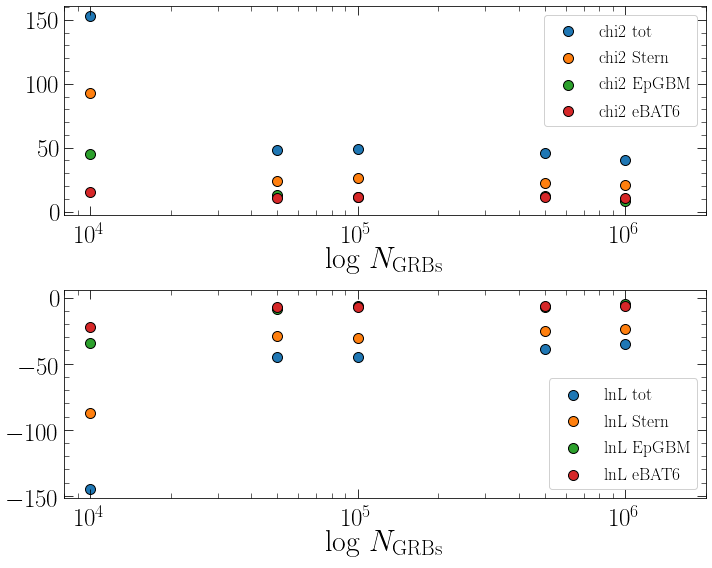

In [16]:
plt.style.use('paper')
fig, axes = plt.subplots(2)
labels_chi2 = ['chi2 tot', 'chi2 Stern', 'chi2 EpGBM', 'chi2 eBAT6']
labels_lnL = ['lnL tot', 'lnL Stern', 'lnL EpGBM', 'lnL eBAT6']
for i in range(chi2.shape[1]):
    axes[0].scatter(Nb_GRBs_list, chi2[:,i], label=labels_chi2[i])
    axes[1].scatter(Nb_GRBs_list, lnL[:,i], label=labels_lnL[i])
axes[0].set_xscale('log')
axes[0].legend()
axes[1].set_xscale('log')
axes[1].legend()
axes[0].set_xlabel(r'log $N_{\rm GRBs}$')
axes[1].set_xlabel(r'log $N_{\rm GRBs}$')
axes[0].set_xlim(8e3, 2e6)
axes[1].set_xlim(8e3, 2e6)

plt.show()

In [9]:
N_repeats = 100
chi2 = np.zeros((N_repeats,4))
lnL = np.zeros((N_repeats,4))
for i, Nb_GRBs in enumerate(N_repeats):
    gp = create_GRB_population_from(Nb_GRBs=Nb_GRBs,
                                    cosmo=cosmo,
                                    params=params,
                                    incl_samples=incl_samples,
                                    incl_instruments=incl_instruments,
                                    incl_constraints=incl_constraints,
                                    output_dir=paths_to_dir['output'])
    chi2[i][0] = gp.likelihood_params['chi2_tot']
    chi2[i][1] = gp.likelihood_params['chi2_Stern']
    chi2[i][2] = gp.likelihood_params['chi2_EpGBM']
    chi2[i][3] = gp.likelihood_params['chi2_eBAT6']
    lnL[i][0] = gp.likelihood_params['lnL_tot']
    lnL[i][1] = gp.likelihood_params['lnL_Stern']
    lnL[i][2] = gp.likelihood_params['lnL_EpGBM']
    lnL[i][3] = gp.likelihood_params['lnL_eBAT6']
    
    
    

(4, 4)

In [7]:
gp = create_GRB_population_from(Nb_GRBs=1e6,
                                    cosmo=cosmo,
                                    params=params,
                                    incl_samples=incl_samples,
                                    incl_instruments=incl_instruments,
                                    incl_constraints=incl_constraints,
                                    output_dir=paths_to_dir['output'],
                               f90=True)

11:57:00.343 [INFO] Starting calculations of peak photon fluxes...
11:57:00.343 [DEBUG] For BATSE instrument [50, 300 keV]:
11:57:11.910 [DEBUG] Done in 11.566 s
11:57:12.084 [INFO] Starting calculations of peak photon fluxes...
11:57:12.085 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
11:57:23.381 [DEBUG] Done in 11.296 s
11:57:23.382 [INFO] Starting calculations of peak energy fluxes...
11:57:23.382 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
11:57:34.851 [DEBUG] Done in 11.468 s
11:57:34.852 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
11:57:46.349 [DEBUG] Done in 11.497 s
11:57:46.350 [DEBUG] Starting calculations of photon fluences...
11:57:46.365 [DEBUG] Done in 0.014 s
11:57:46.365 [DEBUG] Starting calculations of energy fluences...
11:57:46.382 [DEBUG] Done in 0.015 s
11:57:46.382 [INFO] Starting calculations of detection probability...
11:57:46.383 [DEBUG] Stern sample:
11:57:46.391 [DEBUG] Done in 0.007 s
11:57:46.392 [DEBUG] EpGBM sample:
11:57:46.399 [DEBUG] Done in 0

In [8]:
gp2 = create_GRB_population_from(Nb_GRBs=1e6,
                                    cosmo=cosmo,
                                    params=params,
                                    incl_samples=incl_samples,
                                    incl_instruments=incl_instruments,
                                    incl_constraints=incl_constraints,
                                    output_dir=paths_to_dir['output'],
                               f90=False)

11:57:48.259 [INFO] Starting calculations of peak photon fluxes...
11:57:48.259 [DEBUG] For BATSE instrument [50, 300 keV]:
11:57:59.842 [DEBUG] Done in 11.582 s
11:58:00.025 [INFO] Starting calculations of peak photon fluxes...
11:58:00.026 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
11:59:40.266 [DEBUG] Done in 100.240 s
11:59:40.267 [INFO] Starting calculations of peak energy fluxes...
11:59:40.268 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
12:01:19.761 [DEBUG] Done in 99.493 s
12:01:19.762 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
12:03:00.648 [DEBUG] Done in 100.886 s
12:03:00.649 [DEBUG] Starting calculations of photon fluences...
12:03:00.663 [DEBUG] Done in 0.013 s
12:03:00.664 [DEBUG] Starting calculations of energy fluences...
12:03:00.678 [DEBUG] Done in 0.013 s
12:03:00.678 [INFO] Starting calculations of detection probability...
12:03:00.679 [DEBUG] Stern sample:
12:03:00.691 [DEBUG] Done in 0.011 s
12:03:00.691 [DEBUG] EpGBM sample:
12:03:00.699 [DEBUG] Done in

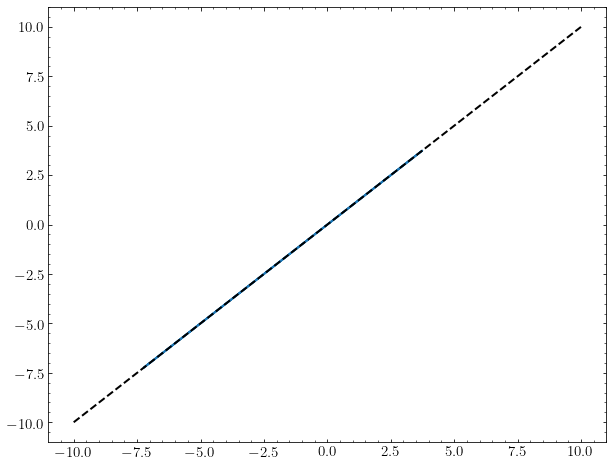

In [20]:
plt.plot(np.log10(gp2.properties['pht_pflx_BAT']), np.log10(gp.properties['pht_pflx_BAT']))
plt.plot(np.linspace(-10,10),np.linspace(-10,10), color='k', ls='--')

In [59]:
gp3 = GRBPopulation(Nb_GRBs=1e6)
gp3.draw_GRB_properties_for_MCMC(cosmo=cosmo,
                             params=params,
                             instruments=incl_instruments)
gp3.create_mock_constraints(constraints=incl_constraints)
gp3.compare_to_observational_constraints(constraints=incl_constraints)

13:02:19.242 [INFO] Starting calculations of peak photon fluxes...
13:02:19.243 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
13:02:31.061 [DEBUG] Done in 11.817 s
13:02:31.061 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
13:02:42.341 [DEBUG] Done in 11.279 s


In [47]:
lnL_Stern_max = st.pBIL(mod=incl_constraints['Stern']['hist'],
        obs=incl_constraints['Stern']['hist'],
        sum_ln_oi_factorial=incl_constraints['Stern']['sum_ln_oi_factorial'], epsilon=1e-3)
lnL_Stern_min = st.pBIL(mod=0.*incl_constraints['Stern']['hist'],
        obs=incl_constraints['Stern']['hist'],
        sum_ln_oi_factorial=incl_constraints['Stern']['sum_ln_oi_factorial'], epsilon=1e-3)

In [24]:
incl_constraints['Stern']

{'instrument': 'BATSE',
 'val_min': 0.066825,
 'prop_min': 'pht_pflx_BATSE',
 'quantity': 'pht_pflx_BATSE',
 'sum_ln_oi_factorial': 36306.10949982049,
 'last_bin': 50.0,
 'bins': array([ 0.066825 ,  0.0841276,  0.10591  ,  0.133333 ,  0.167857 ,
         0.211319 ,  0.266035 ,  0.334918 ,  0.421637 ,  0.53081  ,
         0.66825  ,  0.841276 ,  1.0591   ,  1.33333  ,  1.67857  ,
         2.11319  ,  2.66035  ,  3.34918  ,  4.21637  ,  5.3081   ,
         6.6825   ,  8.41277  , 10.591    , 13.3333   , 16.       ,
        20.       , 28.       , 50.       ]),
 'hist': array([746.998 , 709.321 , 756.005 , 617.559 , 621.942 , 518.764 ,
        425.721 , 379.296 , 340.3   , 301.492 , 291.045 , 247.761 ,
        244.776 , 201.493 , 180.597 , 131.343 , 126.866 ,  83.5821,
         73.1344,  65.6715,  37.3135,  35.8208,  31.3433,  23.8806,
         22.388 ,  17.9104,  16.4179]),
 'err': array([186.75   ,  91.5729 ,  64.8269 ,  43.3442 ,  35.381  ,  28.9998 ,
         25.3513 ,  23.7992 ,  22.5

In [48]:
print("lnL Stern min : {}, max : {}".format(lnL_Stern_min,lnL_Stern_max))

lnL Stern min : -86378.66886242238, max : 0.0001935189648065716


lnL Stern min : -86378.66886242238, max : 0.0001935189648065716


In [46]:
lnL_eBAT6_max = st.pBIL(mod=incl_constraints['eBAT6']['hist'],
        obs=incl_constraints['eBAT6']['hist'],
        sum_ln_oi_factorial=incl_constraints['eBAT6']['sum_ln_oi_factorial'], epsilon=1e-3)
lnL_eBAT6_min = st.pBIL(mod=0.*incl_constraints['eBAT6']['hist'],
        obs=incl_constraints['eBAT6']['hist'],
        sum_ln_oi_factorial=incl_constraints['eBAT6']['sum_ln_oi_factorial'], epsilon=1e-3)

In [49]:
print("lnL eBAT6 min : {}, max : {}".format(lnL_eBAT6_min,lnL_eBAT6_max))

lnL eBAT6 min : -662.3500663892974, max : -0.0020000000000379714


In [50]:
lnL_EpGBM_max = st.pBIL(mod=incl_constraints['EpGBM']['hist'],
        obs=incl_constraints['EpGBM']['hist'],
        sum_ln_oi_factorial=incl_constraints['EpGBM']['sum_ln_oi_factorial'], epsilon=1e-3)
lnL_EpGBM_min = st.pBIL(mod=0.*incl_constraints['EpGBM']['hist'],
        obs=incl_constraints['EpGBM']['hist'],
        sum_ln_oi_factorial=incl_constraints['EpGBM']['sum_ln_oi_factorial'], epsilon=1e-3)

In [52]:
print("L EpGBM min : {}, max : {}".format(10**lnL_EpGBM_min,10**lnL_EpGBM_max))

L EpGBM min : 0.0, max : 1.000000000002094


In [56]:
nbins = len(incl_constraints['EpGBM']['hist'])
nbins

9

In [58]:
nbins_tot = 9+27+15
nbins_tot

51

In [72]:
C_on = np.logspace(-4, 7, 100)
_, pdet, _ = ph.calc_det_prob_SVOM(C_on,
                             t90obs=np.ones(len(C_on)),
                             Cvar=np.ones(len(C_on)),
                             **ECLAIRs_prop)
pdet = pdet/pdet[-1]

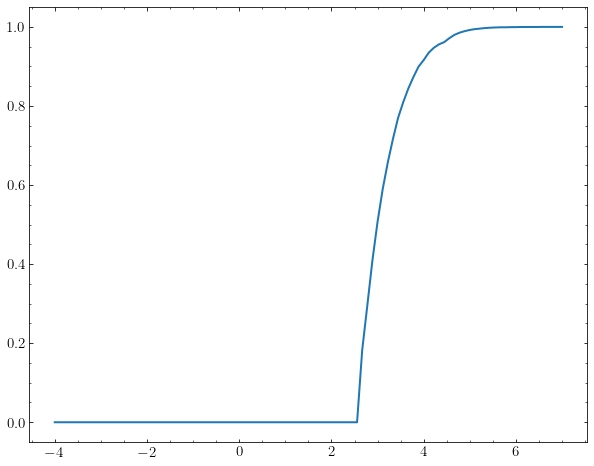

In [73]:
plt.plot(np.log10(C_on), pdet)

In [76]:
C_on50 = C_on[pdet.searchsorted(0.5)]
C_on50

1000.0

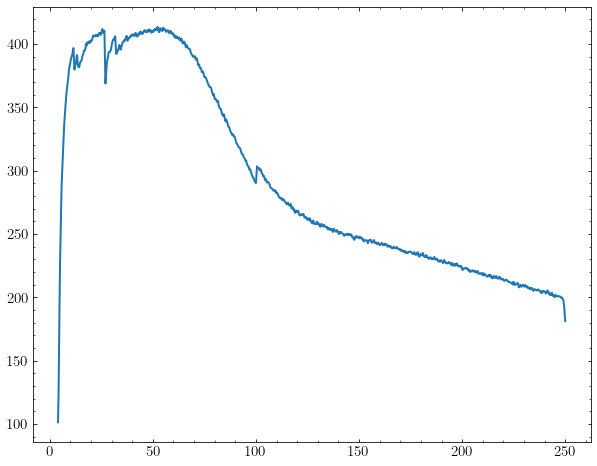

In [78]:
plt.plot(ECLAIRs_prop['eff_area_E'],
         ECLAIRs_prop['eff_area_A'])

In [127]:
gpE = create_GRB_population_from(Nb_GRBs=1e5,
                                    cosmo=cosmo,
                                    params=params,
                                    incl_samples=incl_samples,
                                    incl_instruments=incl_instruments,
                                    incl_constraints=incl_constraints,
                                    output_dir=paths_to_dir['output'],
                                 ECLAIRs_prop=ECLAIRs_prop,
                               f90=True)

14:51:53.280 [INFO] Starting calculations of peak photon fluxes...
14:51:53.280 [DEBUG] For BATSE instrument [50, 300 keV]:
14:51:54.329 [DEBUG] Done in 1.047 s
14:51:54.357 [INFO] Starting calculations of peak photon fluxes...
14:51:54.358 [DEBUG] For ECLAIRs instrument [4.0, 150.0 keV]:
14:51:56.270 [DEBUG] Done in 1.911 s
14:51:56.271 [DEBUG] For ECLAIRsS instrument [4.0, 120.0 keV]:
14:51:57.224 [DEBUG] Done in 0.952 s
14:51:57.224 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
14:51:58.231 [DEBUG] Done in 1.006 s
14:51:58.231 [INFO] Starting calculations of peak energy fluxes...
14:51:58.232 [DEBUG] For BATSE instrument [50.0, 300.0 keV]:
14:51:59.210 [DEBUG] Done in 0.978 s
14:51:59.211 [DEBUG] For ECLAIRs instrument [4.0, 150.0 keV]:
14:52:00.947 [DEBUG] Done in 1.734 s
14:52:00.947 [DEBUG] For ECLAIRsS instrument [4.0, 120.0 keV]:
14:52:01.938 [DEBUG] Done in 0.990 s
14:52:01.939 [DEBUG] For BAT instrument [15.0, 150.0 keV]:
14:52:02.964 [DEBUG] Done in 1.025 s
14:52:02.965 [DEB

In [128]:
gpE.properties['pdet_Goldstein'] = msc.efficiency_correction_Stern(gpE.properties['pht_pflx_BATSE'], norm=1)

In [129]:
N_BATSE = gpE.properties['pdet_Goldstein'].sum()
gpE.properties['pdet_Goldstein_deg'] = np.where(gpE.properties['pdet_Goldstein'] >= 0.50, 1, 0)
gpE.properties['pdet_ECLAIRs_and_BATSE_deg'] = np.where((gpE.properties['pdet_Goldstein'] >= 0.50) & (gpE.properties['pdet_ECLAIRs_tot']/0.16324406656094845 >= 0.50), 1, 0)
N_BATSE_deg = gpE.properties['pdet_Goldstein_deg'].sum()
N_BATSE_and_ECLAIRs_deg = gpE.properties['pdet_ECLAIRs_and_BATSE_deg'].sum()
N_BATSE_deg/gpE.normalization['T_sim']
# N_BATSE_and_ECLAIRs / N_BATSE

712.2833583043538

In [130]:
N_BATSE_and_ECLAIRs_deg/gpE.normalization['T_sim']

345.7072233261735

In [120]:
gpE.properties['pdet_ECLAIRs_tot'].max()


0.16324406656094845

Inputs pflx: ampl=0.061 ph/s/cm2/keV, alpha=0.860, beta=2.140, Epobs=656.354 keV, Ec=737.187 keV
Inputs mflx: ampl=0.007 ph/s/cm2/keV, alpha=1.227, beta=2.045, Epobs=454.193 keV, Ec=480.513 keV
pflx 50-300 keV from integrating observed Band spectrum = 8.90e+00 ph/s/cm2
mflx 50-300 keV from integrating observed Band spectrum = 9.83e-01 ph/s/cm2
Cvar = 0.110
L = 1.24e+53 erg/s
old L (using integration) = 1.21e+53 erg/s
recalculated pflx 50-300 keV = 8.91e+00 ph/s/cm2
pdet Goldstein = 1.000
counts/s 4-120 keV = 5.79e+03 cts/s
pdet ECLAIRs (tot, pflx, flnc) = 0.897, 0.897, 0.873
 
Inputs pflx: ampl=0.022 ph/s/cm2/keV, alpha=1.346, beta=3.017, Epobs=188.971 keV, Ec=482.954 keV
Inputs mflx: ampl=0.007 ph/s/cm2/keV, alpha=1.390, beta=3.091, Epobs=128.557 keV, Ec=358.435 keV
pflx 50-300 keV from integrating observed Band spectrum = 2.47e+00 ph/s/cm2
mflx 50-300 keV from integrating observed Band spectrum = 6.44e-01 ph/s/cm2
Cvar = 0.260
L = 5.59e+51 erg/s
old L (using integration) = 3.59e+51 e

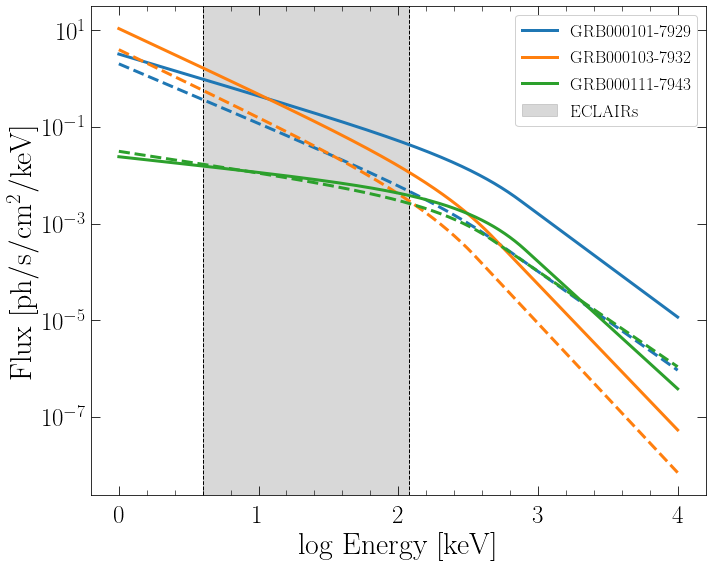

In [225]:
alpha = np.array([0.859567, 1.34607, 0.314555])
alpha_flnc = np.array([1.22741, 1.38982, 0.438737])
beta = np.array([2.14045, 3.01732, 2.63616])
beta_flnc = np.array([2.04477, 3.09109, 1.97715])
Epobs = np.array([656.354, 188.971, 585.414])
Epobs_flnc = np.array([454.193, 128.557, 480.466])
ampl = np.array([0.0614661, 0.0220742, 0.00567956])
ampl_flnc = np.array([0.00709248, 0.00662152, 0.00415313])
t90obs = np.array([51.776, 67.392, 3.456])



E = np.logspace(np.log10(50), np.log10(300), 1000)
E2 = np.logspace(0, 4, 1000)
z = 1.
D_L = cs.Lum_dist(z, cosmo)
plt.style.use('paper')
fig, ax = plt.subplots()
colors=['C0', 'C1', 'C2']
labels=['GRB000101-7929', 'GRB000103-7932', 'GRB000111-7943']
ax.axvline(np.log10(4), ls='--', color='k', lw=1)
ax.axvline(np.log10(120), ls='--', color='k', lw=1)
ax.axvspan(np.log10(4), np.log10(120), alpha=0.3, color='gray', lw=1, label='ECLAIRs')

for i in range(len(alpha)):
    Ec = (beta[i]-alpha[i])*Epobs[i]/(2-alpha[i])
    Ec_flnc = (beta_flnc[i]-alpha_flnc[i])*Epobs_flnc[i]/(2-alpha_flnc[i])
    print("Inputs pflx: ampl={:.3f} ph/s/cm2/keV, alpha={:.3f}, beta={:.3f}, Epobs={:.3f} keV, Ec={:.3f} keV".format(ampl[i],
                                                                                        alpha[i],
                                                                                        beta[i],
                                                                                        Epobs[i],
                                                                                        Ec))
    print("Inputs mflx: ampl={:.3f} ph/s/cm2/keV, alpha={:.3f}, beta={:.3f}, Epobs={:.3f} keV, Ec={:.3f} keV".format(ampl_flnc[i],
                                                                                        alpha_flnc[i],
                                                                                        beta_flnc[i],
                                                                                        Epobs_flnc[i],
                                                                                        Ec_flnc))
    ax.plot(np.log10(E2), Band(E2, ampl[i], alpha[i], beta[i], Epobs[i]), color=colors[i], label=labels[i])
    ax.plot(np.log10(E2), Band(E2, ampl_flnc[i], alpha_flnc[i], beta_flnc[i], Epobs_flnc[i]), color=colors[i], ls='--')

    Ep = Epobs[i] * (1+z)
    x = E/Ep
    ktild = f90f.f90f.calc_ktild(alpha=alpha[i], beta=beta[i], spec='Band')[0]
    # Calculate unitless spectral shape
    B = integrate.trapz(ph.Btild(x, ktild, alpha[i], beta[i], spec='Band'), x)
    # Integrate the observed Band spectrum between 50-300 keV to get peak flux
    pflx = integrate.trapz(Band(E, ampl[i], alpha[i], beta[i], Epobs[i]), E)  # ph/s/cm2 in 50-300 keV at peak
    mflx = integrate.trapz(Band(E, ampl_flnc[i], alpha_flnc[i], beta_flnc[i], Epobs_flnc[i]), E)  # ph/s/cm2 in 50-300 keV
    print("pflx 50-300 keV from integrating observed Band spectrum = {:.2e} ph/s/cm2".format(pflx))
    print("mflx 50-300 keV from integrating observed Band spectrum = {:.2e} ph/s/cm2".format(mflx))
    Cvar = mflx/pflx
    print('Cvar = {:.3f}'.format(Cvar))
    L2 = pflx * (4.*np.pi*(D_L*cst.Mpc)**2*Ep*cst.keV) / (B*(1.+z))
    L = calc_L(D_L, Epobs[i], ampl[i], alpha[i], ktild, Epivot=100)
    # Original equation:
    # B = integrate.trapz(Btild(x, ktild, alpha, beta, spec='Band'), x)
    # pflx = B * (1.+z) * L/(4.*np.pi*Ep*cst.keV*(D_L*cst.Mpc)**2)  # in cgs (ph/cm2/s)
    print("L = {:.2e} erg/s".format(L))
    print("old L (using integration) = {:.2e} erg/s".format(L2))
    
    pflx_BATSE = ph.pht_flux(L, z, Ep, D_L, alpha[i], beta[i], ktild, Emin=50, Emax=300, spec='Band')
    print("recalculated pflx 50-300 keV = {:.2e} ph/s/cm2".format(pflx_BATSE))
    pdet_Goldstein = msc.efficiency_correction_Stern(pflx_BATSE, norm=1)
    print("pdet Goldstein = {:.3f}".format(pdet_Goldstein))
    
    cts = ph.cts_flux_ECLAIRs(L, z, Ep, D_L, alpha[i], beta[i], ktild, spec='Band',
                            Emin=4,
                            Emax=120,
                            eff_area_A_tot=ECLAIRs_prop['eff_area_A'],
                            eff_area_E_tot=ECLAIRs_prop['eff_area_E'])
    print("counts/s 4-120 keV = {:.2e} cts/s".format(cts))

    pdet_tot, pdet_cts, pdet_flnc = ph.calc_det_prob_SVOM(cts,
                                       t90obs=t90obs[i],
                                       Cvar=Cvar,
                                       **ECLAIRs_prop)
    print("pdet ECLAIRs (tot, pflx, flnc) = {:.3f}, {:.3f}, {:.3f}".format(pdet_tot, pdet_cts, pdet_flnc))
    print(' ')

# ax.set_xscale('log')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('log Energy [keV]')
ax.set_ylabel(r'Flux [$\rm ph/s/cm^2/keV$]')

fig.savefig('/Users/palmerio/Desktop/Band_spec_test_Sarah.pdf', bbox_inches='tight')


In [27]:

def calc_L(ampl, alpha, ktild, Epobs, D_L=6701.769533325241,  Epiv=100):
    L = 1./ktild * 4*np.pi * (D_L*cst.Mpc)**2 * (Epobs*Epobs*cst.keV) * ampl * ((Epobs/Epiv)**(-alpha))
    return L

def Band(E, ampl, alpha, beta, Ep, Epiv=100.):
    if isinstance(alpha, np.ndarray):
        ampl = ampl[:,np.newaxis]
        alpha = alpha[:,np.newaxis]
        beta = beta[:,np.newaxis]
        Ep = Ep[:,np.newaxis]
        try:
            Epiv = Epiv[:,np.newaxis]
        except TypeError:
            pass
    Ec = (beta-alpha)*Ep/(2-alpha)
    spec_L = ampl* (E/Epiv)**(-alpha) * np.exp(-(2-alpha)*E/Ep)
    spec_H = ampl* (E/Epiv)**(-beta) * (Ec/Epiv)**(beta-alpha) * np.exp(alpha-beta)
    spec = np.where(E <= Ec, spec_L, spec_H)
    return spec

def calc_flux_from_Band_params(ampl, alpha, beta, Epobs, Emin, Emax, Epiv=100., z=1, verbose=True):
    Ec = (beta-alpha)*Epobs/(2-alpha)  # keV   
    Ep = Epobs * (1+z)                 # keV source frame
    if verbose:
        print("Inputs: ampl={:.3f} ph/s/cm2/keV, alpha={:.3f}, beta={:.3f},"
              " Epobs={:.3f} keV, Ec={:.3f} keV".format(ampl, alpha, beta, Epobs, Ec))
    E = np.logspace(np.log10(Emin), np.log10(Emax), 1000)
    # Integrate the observed Band spectrum between [Emin-Emax] keV to get peak flux
    flux = integrate.trapz(Band(E, ampl, alpha, beta, Epobs, Epiv=Epiv).T, E, axis=0)  # ph/s/cm2 in [Emin-Emax] keV at peak
    return flux


def calc_pdet_from_Band_params(df, Emin, Emax, z=None):
    """
        Assumes the GRB is at a redshift of 1 by default.
    """
    
    ampl = df['ampl'].to_numpy()
    alpha = df['alpha'].to_numpy()
    beta = df['beta'].to_numpy()
    Epobs = df['Epobs'].to_numpy()
    Cvar = df['Cvar'].to_numpy()
    t90obs = df['t90obs'].to_numpy()
    Epiv = df['Epiv'].to_numpy()

    if z is None:
        z = np.ones(len(alpha))
    D_L = Lum_dist(z, cosmo=cosmo)
    Ep = Epobs * (1+z)

    # Calculate ktild
    ktild = f90f.f90f.calc_ktild(alpha=df['alpha'], beta=df['beta'], spec='Band')
    df['ktild'] = ktild
    
    # Calculate Lbol and peak fluxes
    Lbol = calc_L(ampl, alpha, ktild, Epobs, D_L=D_L, Epiv=Epiv)
    df['Lbol'] = Lbol
    df['pflx_ECL'] = calc_flux_from_Band_params(ampl, alpha, beta, Epobs, Emin=Emin, Emax=Emax, Epiv=Epiv, z=z, verbose=False)
    df['pcts_ECL'] = ph.cts_flux_ECLAIRs(Lbol, z, Ep, D_L, alpha, beta, ktild, spec='Band', Emin=Emin, Emax=Emax,
                               eff_area_A_tot=ECLAIRs_prop['eff_area_A'],
                               eff_area_E_tot=ECLAIRs_prop['eff_area_E'])
    
    pdet_tot, pdet_cts, pdet_flnc = ph.calc_det_prob_SVOM(df['pcts_ECL'].to_numpy(), t90obs=t90obs, Cvar=Cvar,
                                                          **ECLAIRs_prop)
    df['pdet_tot'] = pdet_tot * (4.*np.pi/ECLAIRs_prop['omega_ECLAIRs_tot'])
    df['pdet_cts'] = pdet_cts * (4.*np.pi/ECLAIRs_prop['omega_ECLAIRs_tot'])
    df['pdet_flnc'] = pdet_flnc * (4.*np.pi/ECLAIRs_prop['omega_ECLAIRs_tot'])
    return df

ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                            Emin=4.,
                            Emax=120.,
                            n_sigma=6.5)
cosmo = init_cosmology(paths_to_dir['cosmo'])


13:28:18.920 [DEBUG] ==============================================
13:28:18.920 [DEBUG] ===           ECLAIRs instrument           ===
13:28:18.921 [DEBUG] ==============================================
13:28:18.922 [DEBUG] ECLAIRs energy channel: 4.0 to 120.0 keV
13:28:18.922 [DEBUG] ECLAIRs detection level: 6.5 sigmas
13:28:18.948 [DEBUG] Effective area: from 1.013650e+02 cm2 at 4.00 keV
13:28:18.949 [DEBUG] Effective area: to   1.811580e+02 cm2 at 250.00 keV
13:28:18.950 [DEBUG] Background: from 2.819620e+02 cts/s/keV at 4.00 keV
13:28:18.951 [DEBUG] Background: to   8.730200e-02 cts/s/keV at 250.00 keV
13:28:18.952 [DEBUG] ECLAIRs background: 3.075475e+03 cts/s from 4.00 keV to 120.00 keV
13:28:18.952 [DEBUG] ==============================================
13:28:18.955 [DEBUG] Read cosmology from directory /Users/palmerio/Science_projects/GRB_population_model/data/cosmology: [0.3, 0.7, 0.7]


In [37]:
fname = 'catalog_BATSE_GG_BAND.bursts.6500.0040.1200.jesse.dat'
cols = ['Epiv', 'ampl', 'alpha', 'beta', 'Epobs', 'Cvar', 't90obs',
        'det_tscale', 'pflx_on_det_tscale', 'pdet', 'name']
df = pd.read_csv(fname, names=cols, sep='\s+')

# Adjust for opposite convention
df['alpha'] = -df['alpha']
df['beta'] = -df['beta']

# Filter out bad values of alpha and beta
cond = (df['beta'] < 100) & (df['beta'] > 2) & (df['alpha'] < 2) & (df['t90obs'] > 2)
df = df[cond].copy()
df

,Epiv,ampl,alpha,beta,Epobs,Cvar,t90obs,det_tscale,pflx_on_det_tscale,pdet,name
0,100.0,0.147812,1.227410,2.04477,454.1930,0.047983,51.776,20.48,12.406100,0.952714,000101_7929
1,100.0,0.070559,1.389820,3.09109,128.5570,0.093843,67.392,20.48,10.817600,0.947423,000103_7932
2,100.0,0.008611,1.907350,4.54138,1029.6800,0.120788,23.680,10.24,3.489340,0.807107,000104-_7934
3,100.0,0.037596,0.652132,3.82272,375.9530,0.040439,39.424,0.32,3.960100,0.431166,000107-_7936
4,100.0,0.055160,1.136540,5.53485,172.3410,0.081259,294.784,20.48,4.720120,0.896459,000107-_7938
...,...,...,...,...,...,...,...,...,...,...,...
2015,100.0,6.235790,-1.008590,5.49385,46.0939,0.113364,6.208,5.12,1.766720,0.642711,991201_7888
2016,100.0,0.037280,0.954957,3.02544,306.9500,0.087052,60.800,20.48,1.716280,0.769891,991210-_7900
2018,100.0,0.064117,1.131290,3.14140,87.8789,0.061178,47.104,10.24,3.692750,0.831220,991211-_7902
2020,100.0,1.144860,1.197350,2.21719,382.4310,0.049078,15.168,5.12,167.864000,0.994400,991216_7906


In [38]:
# Calculate probability detection and other params
df = calc_pdet_from_Band_params(df, Emin=4, Emax=120)
df

,Epiv,ampl,alpha,beta,Epobs,Cvar,t90obs,det_tscale,pflx_on_det_tscale,pdet,name,ktild,Lbol,pflx_ECL,pcts_ECL,pdet_tot,pdet_cts,pdet_flnc
0,100.0,0.147812,1.227410,2.04477,454.1930,0.047983,51.776,20.48,12.406100,0.952714,000101_7929,0.088677,4.528528e+53,69.472056,24429.817050,0.958385,0.958385,0.905435
1,100.0,0.070559,1.389820,3.09109,128.5570,0.093843,67.392,20.48,10.817600,0.947423,000103_7932,0.471137,1.473174e+52,41.845779,14385.634120,0.939902,0.939902,0.920805
2,100.0,0.008611,1.907350,4.54138,1029.6800,0.120788,23.680,10.24,3.489340,0.807107,000104-_7934,0.077821,1.158909e+52,16.779861,5411.723569,0.864704,0.864704,0.793342
3,100.0,0.037596,0.652132,3.82272,375.9530,0.040439,39.424,0.32,3.960100,0.431166,000107-_7936,1.604728,1.178212e+52,6.865677,2511.374453,0.748121,0.748121,0.329270
4,100.0,0.055160,1.136540,5.53485,172.3410,0.081259,294.784,20.48,4.720120,0.896459,000107-_7938,0.798920,9.322079e+51,20.202970,7148.399642,0.916080,0.893563,0.916080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,100.0,6.235790,-1.008590,5.49385,46.0939,0.113364,6.208,5.12,1.766720,0.642711,991201_7888,13.420694,3.814492e+51,14.001275,5442.229123,0.865359,0.865359,0.638954
2016,100.0,0.037280,0.954957,3.02544,306.9500,0.087052,60.800,20.48,1.716280,0.769891,991210-_7900,0.946202,1.073435e+52,10.565864,3801.720019,0.816302,0.816302,0.753868
2018,100.0,0.064117,1.131290,3.14140,87.8789,0.061178,47.104,10.24,3.692750,0.831220,991211-_7902,0.741245,6.524483e+51,20.594763,7245.992752,0.894833,0.894833,0.781046
2020,100.0,1.144860,1.197350,2.21719,382.4310,0.049078,15.168,5.12,167.864000,0.994400,991216_7906,0.331677,8.548737e+53,504.792922,178057.074464,0.996230,0.996230,0.965048


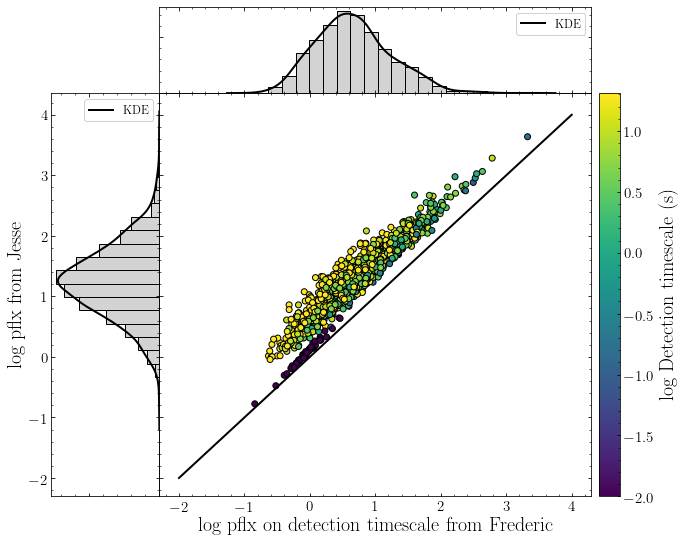

In [39]:
fig, axes = pf.cool_hist2d(np.log10(df['pflx_on_det_tscale']),
                           np.log10(df['pflx_ECL']),
                           c=np.log10(df['det_tscale']),
                           mode='scatter', cblabel='log Detection timescale (s)')
x = np.linspace(-2,4)
axes['center'].plot(x,x, lw=2, c='k')
axes['center'].set_xlabel('log pflx on detection timescale from Frederic')
axes['left'].set_ylabel('log pflx from Jesse')
# fig.savefig('pflx_ecl_comparaison_frederic.pdf', bbox_inches='tight')
plt.show()


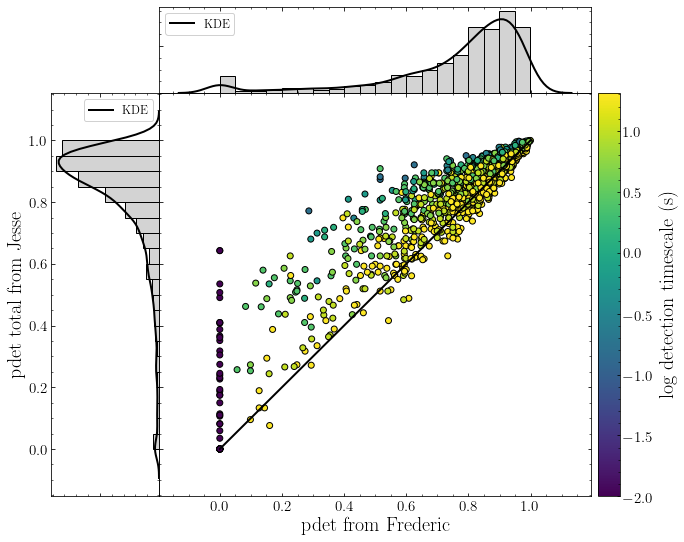

In [40]:
fig, axes = pf.cool_hist2d(df['pdet'],
                           df['pdet_tot'],
                           c=np.log10(df['det_tscale']),
                           mode='scatter', cblabel='log detection timescale (s)')
x = np.linspace(0,1)
axes['center'].plot(x,x, lw=2, c='k')
axes['center'].set_xlabel('pdet from Frederic')
axes['left'].set_ylabel('pdet total from Jesse')
# fig.savefig('pdet_ecl_comparaison_frederic.pdf', bbox_inches='tight')
plt.show()


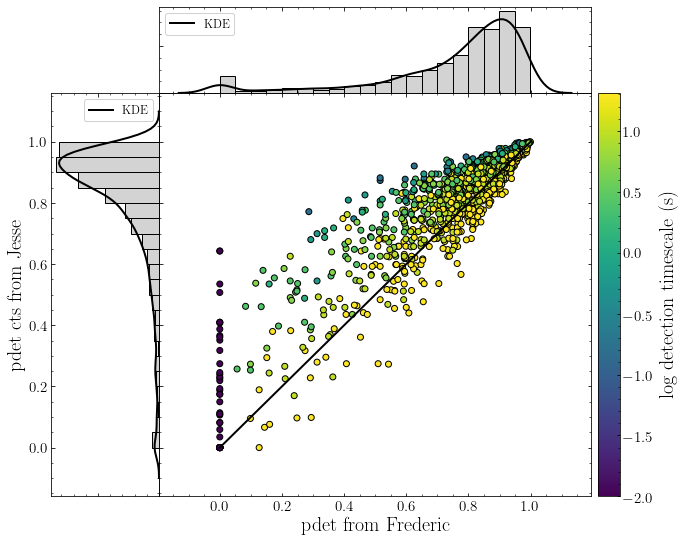

In [41]:
fig, axes = pf.cool_hist2d(df['pdet'],
                           df['pdet_cts'],
                           c=np.log10(df['det_tscale']),
                           mode='scatter', cblabel='log detection timescale (s)')
x = np.linspace(0,1)
axes['center'].plot(x,x, lw=2, c='k')
axes['center'].set_xlabel('pdet from Frederic')
axes['left'].set_ylabel('pdet cts from Jesse')
# fig.savefig('pdet_ecl_comparaison_frederic.pdf', bbox_inches='tight')
plt.show()

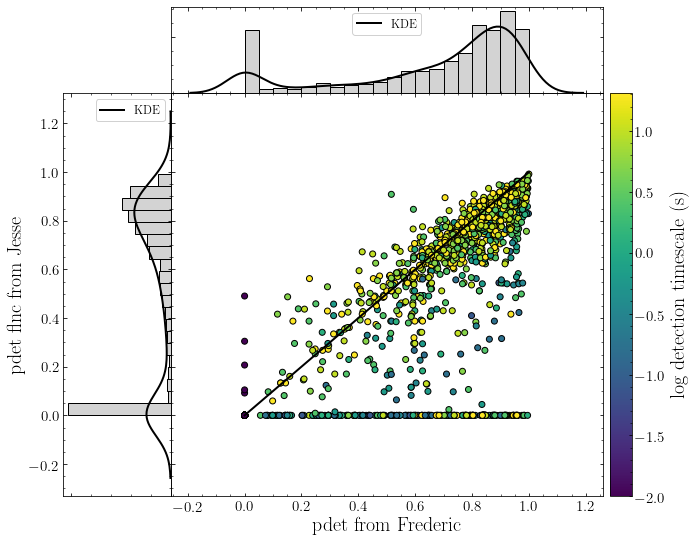

In [34]:
fig, axes = pf.cool_hist2d(df['pdet'],
                           df['pdet_flnc'],
                           c=np.log10(df['det_tscale']),
                           mode='scatter', cblabel='log detection timescale (s)')
x = np.linspace(0,1)
axes['center'].plot(x,x, lw=2, c='k')
axes['center'].set_xlabel('pdet from Frederic')
axes['left'].set_ylabel('pdet flnc from Jesse')
# fig.savefig('pdet_ecl_comparaison_frederic.pdf', bbox_inches='tight')
plt.show()

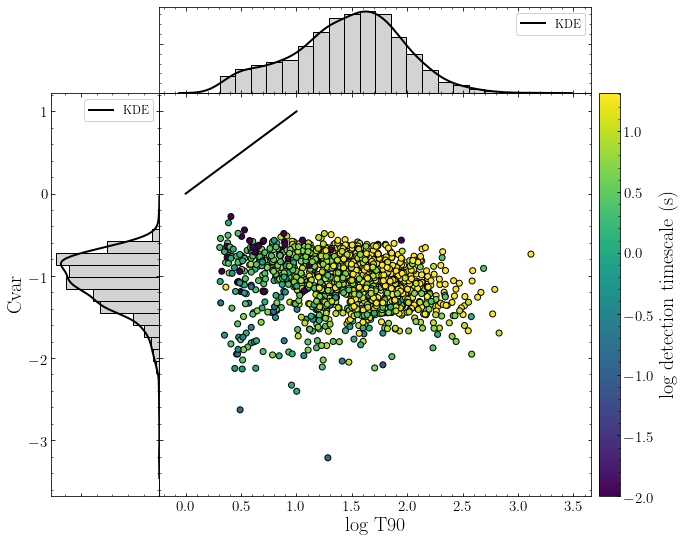

In [43]:
fig, axes = pf.cool_hist2d(np.log10(df['t90obs']),
                           np.log10(df['Cvar']),
                           c=np.log10(df['det_tscale']),
                           mode='scatter', cblabel='log detection timescale (s)')
axes['center'].set_xlabel('log T90')
axes['left'].set_ylabel('log Cvar')
# fig.savefig('pdet_ecl_comparaison_frederic.pdf', bbox_inches='tight')
plt.show()

In [7]:
############### INPUTS ###############
## GRB000101
z = 1.00000E+00
D_L = 2.06795E+28 # cm
D_L = D_L / cst.Mpc
print(D_L)
t90obs = 5.17760E+01 # s
Emin = 4 # keV
Emax = 120 # keV

# fluence spectrum
ampl = 7.09248E-03 # ph/s/cm2/keV
Ep  = 9.08386E+02 # keV (source frame)
Epobs = Ep/(1+z)
alpha = 1.22741E+00 
beta = 2.04477E+00

print(' ')
print('Fluence spectrum :')
ktild = f90f.f90f.calc_ktild(alpha=alpha, beta=beta, spec='Band')[0]
print(f'ktild = {ktild:.3e}')
Lbol = calc_L(ampl, alpha, ktild, Epobs, Epiv=100)
print(f'Lbol = {Lbol:.3e} erg/s')
mflx = calc_flux_from_Band_params(ampl, alpha, beta, Epobs, Emin, Emax, z=z, verbose=True)
print('Mean flux = {:.3e} ph/s/cm2 between {:.0f} and {:.0f} keV'.format(mflx, Emin, Emax))
mflx_B = calc_flux_from_Band_params(ampl, alpha, beta, Epobs, 50, 300, z=z, verbose=True)
print('Mean flux = {:.3e} ph/s/cm2 between {:.0f} and {:.0f} keV'.format(mflx_B, 50, 300))
pdet_Goldstein = msc.efficiency_correction_Stern(mflx_B, norm=1)
print("pdet Goldstein = {:.3f}".format(pdet_Goldstein))

mcts = ph.cts_flux_ECLAIRs(Lbol, z, Ep, D_L, alpha, beta, ktild, spec='Band', Emin=Emin, Emax=Emax,
                           eff_area_A_tot=ECLAIRs_prop['eff_area_A'],
                           eff_area_E_tot=ECLAIRs_prop['eff_area_E'])
print('Mean counts = {:.3e} ct/s/cm2 between {:.0f} and {:.0f} keV'.format(mcts, Emin, Emax))

# Peak spectrum
ampl = 1.47812E-01 # ph/s/cm2/keV
Ep  = 9.08386E+02 # keV (source frame)
Epobs = Ep/(1+z)
alpha = 1.22741E+00 
beta = 2.04477E+00
print(' ')
print('Peak spectrum :')
ktild = f90f.f90f.calc_ktild(alpha=alpha, beta=beta, spec='Band')[0]
print(f'ktild = {ktild:.3e}')
Lbol = calc_L(ampl, alpha, ktild, Epobs, Epiv=100)
print(f'Lbol = {Lbol:.3e} erg/s')
pflx = calc_flux_from_Band_params(ampl, alpha, beta, Epobs, Emin, Emax, z=z, verbose=True)
print('Peak flux = {:.3e} ph/s/cm2 between {:.0f} and {:.0f} keV'.format(pflx, Emin, Emax))
pflx_B = calc_flux_from_Band_params(ampl, alpha, beta, Epobs, 50, 300, z=z, verbose=True)
print('Peak flux = {:.3e} ph/s/cm2 between {:.0f} and {:.0f} keV'.format(pflx_B, 50, 300))
pdet_Goldstein = msc.efficiency_correction_Stern(pflx_B, norm=1)
print("pdet Goldstein = {:.3f}".format(pdet_Goldstein))
pcts = ph.cts_flux_ECLAIRs(Lbol, z, Ep, D_L, alpha, beta, ktild, spec='Band', Emin=Emin, Emax=Emax,
                           eff_area_A_tot=ECLAIRs_prop['eff_area_A'],
                           eff_area_E_tot=ECLAIRs_prop['eff_area_E'])
print('Peak counts = {:.3e} ct/s/cm2 between {:.0f} and {:.0f} keV'.format(pcts, Emin, Emax))

Cvar = mflx/pflx
print('Cvar = {:.3f}'.format(Cvar))


pdet_tot, pdet_cts, pdet_flnc = ph.calc_det_prob_SVOM(pcts, t90obs=t90obs, Cvar=Cvar,
                                                      **ECLAIRs_prop)
print("pdet ECLAIRs (tot, pflx, flnc) = {:.3f}, {:.3f}, {:.3f}".format(pdet_tot, pdet_cts, pdet_flnc))

6701.769533325241
 
Fluence spectrum :
ktild = 8.868e-02
Lbol = 2.217e+52 erg/s
Inputs: ampl=0.007 ph/s/cm2/keV, alpha=1.227, beta=2.045, Epobs=454.193 keV, Ec=480.513 keV
Mean flux = 3.333e+00 ph/s/cm2 between 4 and 120 keV
Inputs: ampl=0.007 ph/s/cm2/keV, alpha=1.227, beta=2.045, Epobs=454.193 keV, Ec=480.513 keV
Mean flux = 9.833e-01 ph/s/cm2 between 50 and 300 keV
pdet Goldstein = 1.000
Mean counts = 1.172e+03 ct/s/cm2 between 4 and 120 keV
 
Peak spectrum :
ktild = 8.868e-02
Lbol = 4.620e+53 erg/s
Inputs: ampl=0.148 ph/s/cm2/keV, alpha=1.227, beta=2.045, Epobs=454.193 keV, Ec=480.513 keV
Peak flux = 6.947e+01 ph/s/cm2 between 4 and 120 keV
Inputs: ampl=0.148 ph/s/cm2/keV, alpha=1.227, beta=2.045, Epobs=454.193 keV, Ec=480.513 keV
Peak flux = 2.049e+01 ph/s/cm2 between 50 and 300 keV
pdet Goldstein = 1.000
Peak counts = 2.443e+04 ct/s/cm2 between 4 and 120 keV
Cvar = 0.048
pdet ECLAIRs (tot, pflx, flnc) = 0.156, 0.156, 0.148


In [20]:

Epiv = 100
Emin = 4
Emax = 120
alpha = np.asarray([0.6,0.6])
beta = np.asarray([2.5,2.5])
ampl = np.asarray([0.5,0.5])
Epobs = np.asarray([500,500])

E = np.logspace(np.log10(Emin), np.log10(Emax), 10)

# flux = integrate.trapz(Band(E, ampl, alpha, beta, Epobs, Epiv=Epiv).T, E, axis=0)  # ph/s/cm2 in [Emin-Emax] keV at peak
# flux
if isinstance(alpha, np.ndarray):
    print('We tried to add axis')
    ampl = ampl[:,np.newaxis]
    alpha = alpha[:,np.newaxis]
    beta = beta[:,np.newaxis]
    Ep = Epobs[:,np.newaxis]

Ec = (beta-alpha)*Ep/(2-alpha)
spec_L = ampl* (E/Epiv)**(-alpha) * np.exp(-(2-alpha)*E/Ep)
spec_H = ampl* (E/Epiv)**(-beta) * (Ec/Epiv)**(beta-alpha) * np.exp(alpha-beta)
spec = np.where(E <= Ec, spec_L, spec_H)
spec

We tried to add axis


array([[3.41090726, 2.70496349, 2.14006562, 1.68731386, 1.32367185,
        1.03080698, 0.7941877 , 0.60239555, 0.44661801, 0.32028626],
       [3.41090726, 2.70496349, 2.14006562, 1.68731386, 1.32367185,
        1.03080698, 0.7941877 , 0.60239555, 0.44661801, 0.32028626]])

In [16]:
alpha = 0.6
beta = 2.5
ampl = 0.5
Epobs = 500

E = np.logspace(np.log10(Emin), np.log10(Emax), 10)

# flux = integrate.trapz(Band(E, ampl, alpha, beta, Epobs, Epiv=Epiv).T, E, axis=0)  # ph/s/cm2 in [Emin-Emax] keV at peak
# flux
Ec = (beta-alpha)*Ep/(2-alpha)
spec_L = ampl* (E/Epiv)**(-alpha) * np.exp(-(2-alpha)*E/Ep)
spec_H = ampl* (E/Epiv)**(-beta) * (Ec/Epiv)**(beta-alpha) * np.exp(alpha-beta)
spec = np.where(E <= Ec, spec_L, spec_H)
spec

array([3.42812524, 2.72491156, 2.16313442, 1.71392049, 1.35423965,
       1.06572689, 0.83375062, 0.64668168, 0.49532866, 0.37251293])

In [44]:
x = np.arange(0,10, 1)
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [53]:
y = x[:,np.newaxis] * np.ones(5)
np.transpose(y)

array([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]])

In [56]:
y = np.tile(x, (5,2))
y

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [64]:
import scipy
rv = scipy.stats.norm(0, 1)
x = rv.cdf(-np.inf) - rv.cdf(-1.63)
x

-0.051550748490089365

In [80]:
x = scipy.stats.norm.cdf(-2, 0, 1)
print(x)

0.022750131948179195


0.10567483084876363